In [ ]:
try:
    #import google.colab # type: ignore
    #from google.colab import output
    %pip install sae-lens transformer-lens circuitsvis
except:
    from IPython import get_ipython # type: ignore
    ipython = get_ipython(); assert ipython is not None
    ipython.run_line_magic("load_ext", "autoreload")
    ipython.run_line_magic("autoreload", "2")

In [ ]:
import transformer_lens
import torch
import pandas as pd
import matplotlib.pyplot as plt

## Loading the Annotated Dataset

In [ ]:
gendered_data = pd.read_csv('https://pratik-doshi-99.github.io/data_files/gender_data.csv')
gendered_data.head(10)

,Word,Gender,Category
0,Abigail,Female,Name
1,Adeline,Female,Name
2,Admiral,Male,Common Noun
3,Adventuress,Female,Common Noun
4,Alethea,Female,Name
5,Alexander,Male,Name
6,Alexis,Female,Name
7,Alice,Female,Name
8,Ambassador,Male,Common Noun
9,Amelia,Female,Name


In [ ]:
gendered_data.shape

(312, 3)

## Loading Pre-trained Model

In [ ]:
# Load the pre-trained "tiny-stories-1L-21M" model
model_name = "tiny-stories-1L-21M"  # Replace this with the actual model name
raw_model = transformer_lens.HookedTransformer.from_pretrained(model_name)

Loaded pretrained model tiny-stories-1L-21M into HookedTransformer


In [ ]:
# here we use generate to get 10 completeions with temperature 1. Feel free to play with the prompt to make it more interesting.
for i in range(5):
    display(
        raw_model.generate(
            "Once upon a time",
            stop_at_eos=False,  # avoids a bug on MPS
            temperature=0.5,
            verbose=False,
            max_new_tokens=50,
        )
    )

'Once upon a time, there was a little girl named Mary. She loved to play outside and explore the world. One day, she decided to go on an adventure. She packed her bag and set off.\n\nAs she walked through the forest, she saw lots'

'Once upon a time there was a little girl named Daisy. She was three years old and loved to explore. One day she decided to go on an adventure. She packed her bag and set off.\n\nAs Daisy walked through the woods, she saw a big,'

'Once upon a time, there was a little girl called Daisy. She was three years old and loved to explore. One day, Daisy was walking in the garden when she saw a big, tall tree. She wanted to climb it, so she asked her mom if she'

'Once upon a time, there was a little girl named Lucy. She was very curious and loved to explore. One day, she decided to go on an adventure. She wanted to see what was beyond the horizon.\n\nSo she put on her shoes and started walking'

'Once upon a time, there was a little girl named Jane. She was only three years old and she loved to do things. She especially loved to play with her toys.\n\nOne day, Jane wanted to play with her toy car. She asked her mom if'

## Tokenizing the prompts and Setting Up Hooks

In [ ]:
prompts = list(gendered_data['Word'])
batch_tokens = raw_model.tokenizer(prompts, return_tensors="pt", padding=True)['input_ids']
batch_tokens.shape # batch dimension, time dimension

torch.Size([312, 4])

In [ ]:
mlp_activations = []
def capture_mlp_activations(module, ip, output):
    #print(ip)
    mlp_activations.append(output.detach().cpu())

# Register hooks to capture MLP activations at each layer
# Assuming the MLP layers are named "mlp" in the model (adjust if necessary)
for layer_index in range(raw_model.cfg.n_layers):
    raw_model.blocks[layer_index].mlp.register_forward_hook(capture_mlp_activations)

## Model Token Context Testing (Not important)

This section is not important. It was written to play around with the model and get a clear picture of how context works in the forward pass.

In [ ]:
eg_token = batch_tokens[0]

In [ ]:
mlp_activations = []
no_context_embedding = eg_token.reshape(len(eg_token),-1)
no_context_embedding

with torch.no_grad():
    raw_model(no_context_embedding)

print(mlp_activations[0].shape) #shape of output tensor
exp1 = mlp_activations[0].squeeze(1)
print(exp1.shape) # batch * sample * embedding dimensions

torch.Size([4, 1, 1024])
torch.Size([4, 1024])


In [ ]:
mlp_activations = []
context_embedding = eg_token.clone()
mlp_activations = []
print(mlp_activations)
with torch.no_grad():
    raw_model(context_embedding)
print(mlp_activations)
print(mlp_activations[0].shape)
exp2 = mlp_activations[0].squeeze(0)
print(exp2.shape) # batch * sample * embedding dimensions

[]
[tensor([[[-0.4515,  0.4032, -0.1441,  ...,  0.1154,  0.5834,  0.2643],
         [ 0.3742,  0.0929, -0.2444,  ...,  0.3709,  1.2639,  0.4193],
         [ 0.0167,  0.6710, -0.4912,  ...,  0.0497,  1.1304,  0.1132],
         [-0.8192,  0.3767, -0.4370,  ...,  0.0478,  0.3139, -0.1156]]])]
torch.Size([1, 4, 1024])
torch.Size([4, 1024])


In [ ]:
print('Without Previous Token Context:',exp1[-1])
print('With Previous Token Context:',exp2[-1])

Without Previous Token Context: tensor([-1.8401, -0.4987,  0.7532,  ..., -0.8744,  0.6383, -0.2679])
With Previous Token Context: tensor([-0.8192,  0.3767, -0.4370,  ...,  0.0478,  0.3139, -0.1156])


## Computing Activations for Gendered Words

In [ ]:
#Forward pass over the model to capture MLP activations
mlp_activations = []
with torch.no_grad():
    raw_model(batch_tokens)

# Print out the collected MLP activations
for i, activation in enumerate(mlp_activations):
    print(f"Layer {i} MLP activations: {activation.shape}")

activations = torch.mean(mlp_activations[0],dim=1)
print('Final Activations:', activations.shape)

Layer 0 MLP activations: torch.Size([312, 4, 1024])
Final Activations: torch.Size([312, 1024])


## Training the SAE on Tiny Stories

Code Taken from: [Basic SAE Training Tutorial](https://colab.research.google.com/github/jbloomAus/SAELens/blob/main/tutorials/training_a_sparse_autoencoder.ipynb)

In [ ]:
import torch
import os

from sae_lens import LanguageModelSAERunnerConfig, SAETrainingRunner

if torch.cuda.is_available():
    device = "cuda"
elif torch.backends.mps.is_available():
    device = "mps"
else:
    device = "cpu"

print("Using device:", device)
os.environ["TOKENIZERS_PARALLELISM"] = "false"

Using device: cuda


In [ ]:
from transformer_lens import HookedTransformer

model = HookedTransformer.from_pretrained(
    "tiny-stories-1L-21M"
)  # This will wrap huggingface models and has lots of nice utilities.

Loaded pretrained model tiny-stories-1L-21M into HookedTransformer


In [ ]:
# here we use generate to get 10 completeions with temperature 1. Feel free to play with the prompt to make it more interesting.
for i in range(5):
    display(
        model.generate(
            "Once upon a time",
            stop_at_eos=False,  # avoids a bug on MPS
            temperature=1,
            verbose=False,
            max_new_tokens=50,
        )
    )

'Once upon a time, a nice dragon came and burned down the hill and made a fire. Everyone was scared, so the doctor helped put it out.\nThe dragon then said, "Let\'s start the day - it\'s wonderful!" Everyone was so happy that the'

'Once upon a time there was a rat namededy. Sammy loved to hide and make noise. He thought he was the best friend of all - a quiet call from his boss.\n\nSo, Sammy agreed to show off his great hiding spot and started making the leash'

"Once upon a time, there was a smelly uncle. He was very busy and worked around the zoo. One day he had visitors to see the elephants, but he still couldn't hear them. As he approached the rhinoceros noticed him looking very sick."

'Once upon a time, in a very cold ship sailed far. The water was cold, and it was very cold.\n\nThe ship sailed out of the cold sea and graceful.\n\nSuddenly, he saw a big dark cloud in the sky. He knew this'

"Once upon a time, there was a angel. He was a kind and compassionate man. The angel was Lisa's best friend!\n\nOne day Tom found a special magical ring. It was a shiny medal! When the angel touched it, it started to glow!"

In [ ]:
from transformer_lens.utils import test_prompt

# Test the model with a prompt
test_prompt(
    "Once upon a time, there was a little girl named Lily. She lived in a big, happy little girl. On her big adventure,",
    " Lily",
    model,
    prepend_space_to_answer=False,
)

Tokenized prompt: ['<|endoftext|>', 'Once', ' upon', ' a', ' time', ',', ' there', ' was', ' a', ' little', ' girl', ' named', ' Lily', '.', ' She', ' lived', ' in', ' a', ' big', ',', ' happy', ' little', ' girl', '.', ' On', ' her', ' big', ' adventure', ',']
Tokenized answer: [' Lily']


Performance on answer token:
Rank: 1        Logit: 18.81 Prob: 13.46% Token: | Lily|

Top 0th token. Logit: 20.48 Prob: 71.06% Token: | she|
Top 1th token. Logit: 18.81 Prob: 13.46% Token: | Lily|
Top 2th token. Logit: 17.35 Prob:  3.11% Token: | the|
Top 3th token. Logit: 17.26 Prob:  2.86% Token: | her|
Top 4th token. Logit: 16.74 Prob:  1.70% Token: | there|
Top 5th token. Logit: 16.43 Prob:  1.25% Token: | they|
Top 6th token. Logit: 15.80 Prob:  0.66% Token: | all|
Top 7th token. Logit: 15.64 Prob:  0.56% Token: | things|
Top 8th token. Logit: 15.28 Prob:  0.39% Token: | one|
Top 9th token. Logit: 15.24 Prob:  0.38% Token: | lived|


Ranks of the answer tokens: [(' Lily', 1)]

In [ ]:
import circuitsvis as cv  # optional dep, install with pip install circuitsvis

# Let's make a longer prompt and see the log probabilities of the tokens
example_prompt = """Hi, how are you doing this? I'm really enjoying your posts"""
logits, cache = model.run_with_cache(example_prompt)
cv.logits.token_log_probs(
    model.to_tokens(example_prompt),
    model(example_prompt)[0].log_softmax(dim=-1),
    model.to_string,
)
# hover on the output to see the result.

In [ ]:
example_prompt = model.generate(
    "Once upon a time",
    stop_at_eos=False,  # avoids a bug on MPS
    temperature=1,
    verbose=True,
    max_new_tokens=200,
)
logits, cache = model.run_with_cache(example_prompt)
cv.logits.token_log_probs(
    model.to_tokens(example_prompt),
    model(example_prompt)[0].log_softmax(dim=-1),
    model.to_string,
)

  0%|          | 0/200 [00:00<?, ?it/s]

In [ ]:
total_training_steps = 30_000
batch_size = 4096
total_training_tokens = total_training_steps * batch_size

lr_warm_up_steps = 0
lr_decay_steps = total_training_steps // 5  # 20% of training
l1_warm_up_steps = total_training_steps // 20  # 5% of training

cfg = LanguageModelSAERunnerConfig(
    # Data Generating Function (Model + Training Distibuion)
    model_name="tiny-stories-1L-21M",  # our model (more options here: https://neelnanda-io.github.io/TransformerLens/generated/model_properties_table.html)
    hook_name="blocks.0.hook_mlp_out",  # A valid hook point (see more details here: https://neelnanda-io.github.io/TransformerLens/generated/demos/Main_Demo.html#Hook-Points)
    hook_layer=0,  # Only one layer in the model.
    d_in=1024,  # the width of the mlp output.
    dataset_path="apollo-research/roneneldan-TinyStories-tokenizer-gpt2",  # this is a tokenized language dataset on Huggingface for the Tiny Stories corpus.
    is_dataset_tokenized=True,
    streaming=True,  # we could pre-download the token dataset if it was small.
    # SAE Parameters
    mse_loss_normalization=None,  # We won't normalize the mse loss,
    expansion_factor=16,  # the width of the SAE. Larger will result in better stats but slower training.
    b_dec_init_method="zeros",  # The geometric median can be used to initialize the decoder weights.
    apply_b_dec_to_input=False,  # We won't apply the decoder weights to the input.
    normalize_sae_decoder=False,
    scale_sparsity_penalty_by_decoder_norm=True,
    decoder_heuristic_init=True,
    init_encoder_as_decoder_transpose=True,
    normalize_activations="expected_average_only_in",
    # Training Parameters
    lr=5e-5,  # lower the better, we'll go fairly high to speed up the tutorial.
    adam_beta1=0.9,  # adam params (default, but once upon a time we experimented with these.)
    adam_beta2=0.999,
    lr_scheduler_name="constant",  # constant learning rate with warmup. Could be better schedules out there.
    lr_warm_up_steps=lr_warm_up_steps,  # this can help avoid too many dead features initially.
    lr_decay_steps=lr_decay_steps,  # this will help us avoid overfitting.
    l1_coefficient=5,  # will control how sparse the feature activations are
    l1_warm_up_steps=l1_warm_up_steps,  # this can help avoid too many dead features initially.
    lp_norm=1.0,  # the L1 penalty (and not a Lp for p < 1)
    train_batch_size_tokens=batch_size,
    context_size=512,  # will control the lenght of the prompts we feed to the model. Larger is better but slower. so for the tutorial we'll use a short one.
    # Activation Store Parameters
    n_batches_in_buffer=64,  # controls how many activations we store / shuffle.
    training_tokens=total_training_tokens,  # 100 million tokens is quite a few, but we want to see good stats. Get a coffee, come back.
    store_batch_size_prompts=16,
    # Resampling protocol
    use_ghost_grads=False,  # we don't use ghost grads anymore.
    feature_sampling_window=1000,  # this controls our reporting of feature sparsity stats
    dead_feature_window=1000,  # would effect resampling or ghost grads if we were using it.
    dead_feature_threshold=1e-4,  # would effect resampling or ghost grads if we were using it.
    # WANDB
    log_to_wandb=False,  # always use wandb unless you are just testing code.
    wandb_project="sae_lens_tutorial",
    wandb_log_frequency=30,
    eval_every_n_wandb_logs=20,
    # Misc
    device=device,
    seed=42,
    n_checkpoints=0,
    checkpoint_path="checkpoints",
    dtype="float32"
)
# look at the next cell to see some instruction for what to do while this is running.
sparse_autoencoder = SAETrainingRunner(cfg).run()

Run name: 16384-L1-5-LR-5e-05-Tokens-1.229e+08
n_tokens_per_buffer (millions): 0.524288
Lower bound: n_contexts_per_buffer (millions): 0.001024
Total training steps: 30000
Total wandb updates: 1000
n_tokens_per_feature_sampling_window (millions): 2097.152
n_tokens_per_dead_feature_window (millions): 2097.152
We will reset the sparsity calculation 30 times.
Number tokens in sparsity calculation window: 4.10e+06
Loaded pretrained model tiny-stories-1L-21M into HookedTransformer


Estimating norm scaling factor: 100%|██████████████████████████████████████████████████████████████████| 1000/1000 [02:18<00:00,  7.23it/s]
30000| MSE Loss 202.787 | L1 161.568: 100%|█████████████████████████████████████████████| 122880000/122880000 [1:42:09<00:00, 20046.31it/s]


In [ ]:
sparse_autoencoder

TrainingSAE(
  (activation_fn): ReLU()
  (hook_sae_input): HookPoint()
  (hook_sae_acts_pre): HookPoint()
  (hook_sae_acts_post): HookPoint()
  (hook_sae_output): HookPoint()
  (hook_sae_recons): HookPoint()
  (hook_sae_error): HookPoint()
)

In [ ]:
sparse_autoencoder.save_model('final_sae')

## Uploading SAE to Huggingface (Won't run on Colab, Ignore)

In [ ]:
from sae_lens import SAE, upload_saes_to_huggingface

In [ ]:
# checking if model loads successfully from local filesystem
sae_trained = SAE.load_from_pretrained('final_sae')

FileNotFoundError: [Errno 2] No such file or directory: 'final_sae/cfg.json'

In [ ]:
sae_trained

SAE(
  (activation_fn): ReLU()
  (hook_sae_input): HookPoint()
  (hook_sae_acts_pre): HookPoint()
  (hook_sae_acts_post): HookPoint()
  (hook_sae_output): HookPoint()
  (hook_sae_recons): HookPoint()
  (hook_sae_error): HookPoint()
)

In [ ]:
sae_dict = {
    'blocks.0.hook_mlp_out':'final_sae'
}

upload_saes_to_huggingface(
    sae_dict,
    hf_repo_id="pratikdoshi/sparse-autoencoders-1",
)

Uploading SAEs:   0%|          | 0/1 [00:00<?, ?it/s]

No files have been modified since last commit. Skipping to prevent empty commit.


README.md already exists in the repo, skipping upload


## Computing SAE Activations

In [ ]:
from sae_lens import SAE

sae_trained, cfg_dict, sparsity = SAE.from_pretrained("pratikdoshi/sparse-autoencoders-1", "blocks.0.hook_mlp_out")

In [ ]:
with torch.no_grad():
    sae_activations = sae_trained.encode(activations)

In [ ]:
print('Original MLP Activations:',activations.shape) #312 samples * 1024 embedding dimension
print('SAE Activations:',sae_activations.shape) #312 samples * 16384 embedding dimension

Original MLP Activations: torch.Size([312, 1024])
SAE Activations: torch.Size([312, 16384])


## Using Linear Classifier to Probe Gender

In [ ]:
import warnings

# Suppress ConvergenceWarning
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)

In [ ]:
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score

def train_linear_classifier(X_train, y_train, X_test, y_test, print_result=True):
    # Initialize the linear classifier
    linear_clf = LinearSVC()

    # Train the classifier
    linear_clf.fit(X_train, y_train)

    # Make predictions
    y_pred_train = linear_clf.predict(X_train)
    y_pred_test = linear_clf.predict(X_test)

    # Evaluate accuracy
    train_accuracy = accuracy_score(y_train, y_pred_train)
    test_accuracy = accuracy_score(y_test, y_pred_test)

    if print_result:
        print(f"Train Accuracy: {train_accuracy:.4f}")
        print(f"Test Accuracy: {test_accuracy:.4f}")

    return linear_clf, train_accuracy, test_accuracy


In [ ]:
# Configurable Parameter
test_split = 0.25
torch.manual_seed(1024)

# generate the indices for training and testing samples
test_split = int(activations.shape[0] * test_split)
shuffled_indices = torch.randperm(activations.shape[0])

# creating a second pair of shuffled indices for a control group to check if the probe memorized the labels
# This paper discussed the rationale for the same: https://arxiv.org/abs/1909.03368
shuffled_indices_control = torch.randperm(activations.shape[0])


test_indices = shuffled_indices[:test_split]
train_indices = shuffled_indices[test_split:]
test_indices_control = shuffled_indices_control[:test_split]
train_indices_control = shuffled_indices_control[test_split:]

# encode the target variable
encoded_gender = pd.get_dummies(gendered_data['Gender'])['Male'].astype(float)

#split the datasets
train_activations = activations[train_indices,:]
train_sae_activations = sae_activations[train_indices,:]
train_gender = encoded_gender.iloc[train_indices]
train_gender_control = encoded_gender.iloc[train_indices_control]

test_activations = activations[test_indices,:]
test_sae_activations = sae_activations[test_indices,:]
test_gender = encoded_gender.iloc[test_indices]
test_gender_control = encoded_gender.iloc[test_indices_control]

In [ ]:
print('Control Task: Probe Performance on Raw Activations')
# control, activations
linear_probe_activations_control, train_acc_activations_control, test_acc_activations_control  = train_linear_classifier(train_activations, train_gender_control, test_activations, test_gender_control)

print('_'*15)
#control, sae
print('Control Task: Probe Performance on SAE Activations')
linear_probe_sae_control, train_acc_sae_control, test_acc_sae_control = train_linear_classifier(train_sae_activations, train_gender_control, test_sae_activations, test_gender_control)

print('_'*15)

print('Linguisitic Task: Probe Performance on Raw Activations')
linear_probe_activations, train_acc_activations, test_acc_activations = train_linear_classifier(train_activations, train_gender, test_activations, test_gender)

print('_'*15)

print('Linguisitic Task: Probe Performance on SAE Activations')
linear_probe_sae, train_acc_sae, test_acc_sae = train_linear_classifier(train_sae_activations, train_gender, test_sae_activations, test_gender)

print('_'*15)

print('Selectivity of Raw Activitations:',test_acc_activations - test_acc_activations_control)
print('Selectivity of SAE Activitations:',test_acc_sae - test_acc_sae_control)

Control Task: Probe Performance on Raw Activations
Train Accuracy: 1.0000
Test Accuracy: 0.4487
_______________
Control Task: Probe Performance on SAE Activations
Train Accuracy: 0.9060
Test Accuracy: 0.4615
_______________
Linguisitic Task: Probe Performance on Raw Activations
Train Accuracy: 1.0000
Test Accuracy: 0.7051
_______________
Linguisitic Task: Probe Performance on SAE Activations
Train Accuracy: 0.9402
Test Accuracy: 0.4744
_______________
Selectivity of Raw Activitations: 0.25641025641025644
Selectivity of SAE Activitations: 0.012820512820512775


In [ ]:
# Analysing the selectivity variance
from tqdm import tqdm

def selectivity_variance(iterations = 5):
    selectivity_sae = []
    selectivity_activations = []

    linear_probe_activations, train_acc_activations, test_acc_activations = train_linear_classifier(train_activations, train_gender, test_activations, test_gender, print_result=False)
    linear_probe_sae, train_acc_sae, test_acc_sae = train_linear_classifier(train_sae_activations, train_gender, test_sae_activations, test_gender, print_result=False)
    for i in tqdm(range(iterations)):
        torch.manual_seed(1024 + i)

        shuffled_indices_control = torch.randperm(activations.shape[0])
        test_indices_control = shuffled_indices_control[:test_split]
        train_indices_control = shuffled_indices_control[test_split:]
        test_gender_control = encoded_gender.iloc[test_indices_control]
        train_gender_control = encoded_gender.iloc[train_indices_control]

        linear_probe_activations_control, train_acc_activations_control, test_acc_activations_control  = train_linear_classifier(train_activations, train_gender_control, test_activations, test_gender_control, print_result=False)

        linear_probe_sae_control, train_acc_sae_control, test_acc_sae_control = train_linear_classifier(train_sae_activations, train_gender_control, test_sae_activations, test_gender_control, print_result=False)

        selectivity_activations.append(test_acc_activations - test_acc_activations_control)
        selectivity_sae.append(test_acc_sae - test_acc_sae_control)
    return selectivity_activations, selectivity_sae

In [ ]:
selectivity_activations, selectivity_sae = selectivity_variance(iterations = 100)

100%|██████████| 100/100 [01:27<00:00,  1.15it/s]


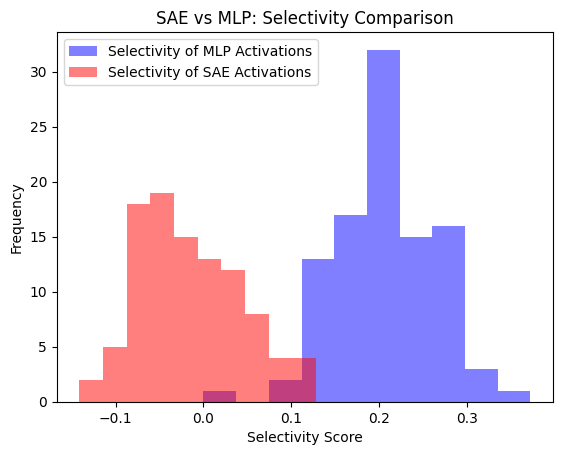

In [ ]:
plt.title('SAE vs MLP: Selectivity Comparison')
plt.hist(selectivity_activations,label='Selectivity of MLP Activations',alpha = 0.5, lw=3, color= 'b')
plt.hist(selectivity_sae,label='Selectivity of SAE Activations',alpha = 0.5, lw=3, color= 'r')
plt.xlabel('Selectivity Score')
plt.ylabel('Frequency')
plt.legend()

## Using Logistic Regression to Assess Statistical Significance in Predicting Gender Label: Logistic Regression Failed to Converge

In [ ]:
import statsmodels.api as sm
from sklearn.metrics import roc_auc_score

def train_logistic_regression_sm(X_train, y_train, X_test=None, y_test=None):
    # Add a constant (bias) term to the training set
    X_train = sm.add_constant(X_train)

    # Fit the logistic regression model
    model = sm.Logit(y_train, X_train)
    result = model.fit()

    # Print the summary
    print(result.summary())

    # Compute training predictions: predicted probabilities
    y_train_pred_prob = result.predict(X_train)

    # Calculate training AUC
    train_auc = roc_auc_score(y_train, y_train_pred_prob)
    print(f"\nTraining AUC: {train_auc:.4f}")
    test_auc = None
    # If test data is provided, calculate test AUC as well
    if X_test is not None and y_test is not None:
        # Add a constant (bias) term to the test set
        X_test = sm.add_constant(X_test)

        # Compute test predictions: predicted probabilities
        y_test_pred_prob = result.predict(X_test)

        # Calculate test AUC
        test_auc = roc_auc_score(y_test, y_test_pred_prob)
        print(f"Testing AUC: {test_auc:.4f}")

    # Print coefficients, standard errors, t-stats, and p-values
    #print("\nCoefficients:\n", result.params)
    #print("\nStandard Errors:\n", result.bse)
    #print("\nT-Statistics:\n", result.tvalues)
    #print("\nP-Values:\n", result.pvalues)

    return result, train_auc, test_auc

In [ ]:
print('Control Task: Logistic Regression on Raw Activations')
# control, activations
logreg_activations_control, train_auc_activations_control, test_auc_activations_control  = train_logistic_regression_sm(train_activations, train_gender_control, test_activations, test_gender_control)

print('_'*15)
#control, sae
print('Control Task: Logistic Regression on SAE Activations')
logreg_sae_control, train_auc_sae_control, test_auc_sae_control = train_logistic_regression_sm(train_sae_activations, train_gender_control, test_sae_activations, test_gender_control)

print('_'*15)

print('Linguisitic Task: Logistic Regression on Raw Activations')
logreg_activations, train_auc_activations, test_auc_activations = train_logistic_regression_sm(train_activations, train_gender, test_activations, test_gender)

print('_'*15)

print('Linguisitic Task: Logistic Regression on SAE Activations')
logreg_sae, train_auc_sae, test_auc_sae = train_logistic_regression_sm(train_sae_activations, train_gender, test_sae_activations, test_gender)

Control Task: Logistic Regression on Raw Activations
         Current function value: inf
         Iterations: 35


LinAlgError: Singular matrix

## Neuron-wise 2 sample t-test: Checking whether SAE's activations better shown gender differences as compared to MLP activations

In [ ]:
male_indices = encoded_gender[encoded_gender == 1.0].index
female_indices = encoded_gender[encoded_gender == 0].index

In [ ]:
male_activations = activations[male_indices,:]
female_activations = activations[female_indices,:]

male_sae_activations = sae_activations[male_indices,:]
female_sae_activations = sae_activations[female_indices,:]

In [ ]:
import numpy as np
from scipy.stats import t as t_dist

def compute_t_stat(male_activations, female_activations):
    male_activations = np.array(male_activations)
    female_activations = np.array(female_activations)

    mean_male = male_activations.mean(axis = 0)
    mean_female = female_activations.mean(axis = 0)

    std_male = male_activations.std(axis = 0, ddof = 1)
    std_female = female_activations.std(axis = 0, ddof = 1)

    n1, n2 = male_activations.shape[0], female_activations.shape[0]

    pool_var = ((std_male**2 / n1) + (std_female**2 / n2))
    d_dof = ((std_male**2 / n1 + std_female**2 / n2) ** 2) / \
         (( (std_male**2 / n1) ** 2 / (n1 - 1) ) + ( (std_female**2 / n2) ** 2 / (n2 - 1) ))

    t_stat = (mean_male - mean_female) / np.sqrt(pool_var)
    print(t_stat.shape)
    p_value = 2 * (1 - t_dist.cdf(np.abs(t_stat), d_dof))

    return t_stat, p_value

In [ ]:
activation_t_stat, activation_p_value = compute_t_stat(male_activations, female_activations)
sae_t_stat, sae_p_value = compute_t_stat(male_sae_activations, female_sae_activations)

(1024,)
(16384,)


In [ ]:
significance_level = 0.99999 #99.999% significance

#Converting to series to preserve the index
activation_p_value = pd.Series(activation_p_value)
sae_p_value = pd.Series(sae_p_value)

significant_activations = activation_p_value[activation_p_value < (1 - significance_level)]
significant_sae = sae_p_value[sae_p_value < (1 - significance_level)]

activation_t_stat = pd.Series(np.abs(activation_t_stat)).sort_values(ascending=False)
sae_t_stat = pd.Series(np.abs(sae_t_stat)).sort_values(ascending=False)

In [ ]:
print('Significant MLP neurons:',significant_activations.shape[0])
print('Significant MLP neurons:',list(significant_activations.index))
print('Significant SAE neurons:',significant_sae.shape[0])
print('Significant SAE neurons:',list(significant_sae.index))

Significant MLP neurons: 9
Significant MLP neurons: [222, 337, 363, 606, 717, 851, 901, 912, 928]
Significant SAE neurons: 2
Significant SAE neurons: [2900, 4223]


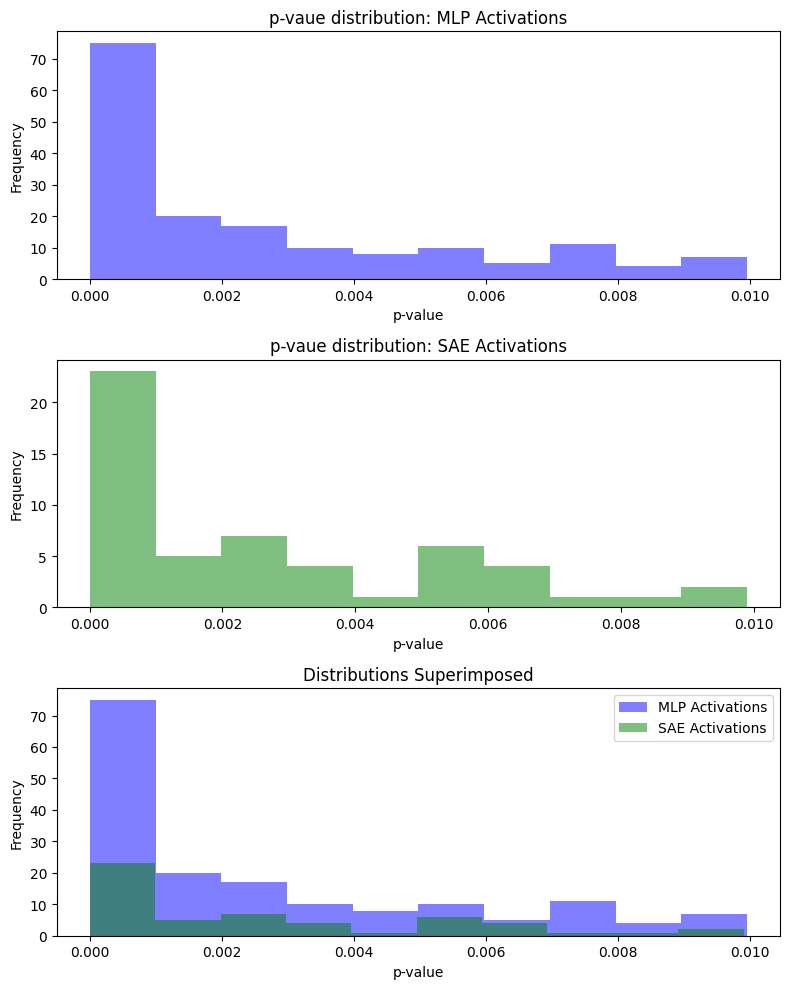

In [ ]:
#zooming at significant p-values
hist_sae_limit = 0.01
hist_p_value_activations = activation_p_value[activation_p_value < hist_sae_limit]
hist_p_value_sae = sae_p_value[sae_p_value < hist_sae_limit]


fig, axs = plt.subplots(3, 1, figsize=(8,10))  # 2 rows, 1 column


# MLP Activations
axs[0].hist(hist_p_value_activations, bins=10, color='blue', alpha=0.5, lw=3)
#axs[0].set_xlim(0, 0.05)
axs[0].set_title('p-vaue distribution: MLP Activations')
axs[0].set_xlabel('p-value')
axs[0].set_ylabel('Frequency')

# SAE Activations
axs[1].hist(hist_p_value_sae, color='green', bins=10, alpha=0.5, lw=3)
#axs[1].set_xlim(0, 0.05)
axs[1].set_title('p-vaue distribution: SAE Activations')
axs[1].set_xlabel('p-value')
axs[1].set_ylabel('Frequency')

#Superimposed
axs[2].hist(hist_p_value_activations, bins=10, color='blue', alpha=0.5, lw=3,label='MLP Activations')
axs[2].hist(hist_p_value_sae, color='green', bins=10, alpha=0.5, lw=3, label='SAE Activations')
#axs[1].set_xlim(0, 0.05)
axs[2].set_title('Distributions Superimposed')
axs[2].set_xlabel('p-value')
axs[2].set_ylabel('Frequency')
axs[2].legend()

# Adjust the layout to prevent overlap
plt.tight_layout()

# Display the plot
plt.show()

## References

1. Basics of Superposition and Sparse Autoencoders: [ARENA SAE tutorial](https://arena3-chapter1-transformer-interp.streamlit.app/[1.4]_Superposition_&_SAEs), [Exercise Solutions](https://colab.research.google.com/drive/1mHKZpkhYAr0WWAQo2Y6pXL08yNfJHOVx?usp=sharing#scrollTo=AWGU8wAn5DS1) and section 4 of [A Primer on the Inner Workings of Transformer-based Language Models](https://arxiv.org/abs/2405.00208)
2. Training a Sparse AutoEncoder: [jloom's tutorial](https://colab.research.google.com/github/jbloomAus/SAELens/blob/main/tutorials/training_a_sparse_autoencoder.ipynb).
3. Code for capturing MLP activations (and other boiler plate code): [ChatGPT](https://chatgpt.com/share/f30f9817-6d10-44bd-947a-b851c014921b)
4. Boiler plate code to train Linear Probes, Logistic Regression and 2 Sample t-test: [ChatGPT](https://chatgpt.com/share/bd78e941-9384-4080-a520-4528ae22574f).
5. Motivation for using Linear Probing techniques: [Redundancy and Concept Analysis for Code-trained Language Models](https://arxiv.org/abs/2305.00875)
6. [Privileged vs non-privileged bases in machine learning](https://harrisonpim.com/blog/privileged-vs-non-privileged-bases-in-machine-learning)